---

# Neural Networks

## Introduction

Neural networks, also known as artificial neural networks (ANNs) or simulated neural networks (SNNs), are a subset of machine learning and are at the heart of deep learning algorithms. Their name and structure are inspired by the human brain, mimicking the way that biological neurons signal to one another.

Artificial neural networks (ANNs) are comprised of a node layers, containing an input layer, one or more hidden layers, and an output layer. Each node, or artificial neuron, connects to another and has an associated weight and threshold. If the output of any individual node is above the specified threshold value, that node is activated, sending data to the next layer of the network. Otherwise, no data is passed along to the next layer of the network.

<img src="DNN.png" width="500" align="center"/>

Neural networks rely on training data to learn and improve their accuracy over time. However, once these learning algorithms are fine-tuned for accuracy, they are powerful tools in computer science and artificial intelligence, allowing us to classify and cluster data at a high velocity. Tasks in speech recognition or image recognition can take minutes versus hours when compared to the manual identification by human experts. One of the most well-known neural networks is Google’s search algorithm.



## Overview the data set

(-0.5, 63.5, 63.5, -0.5)

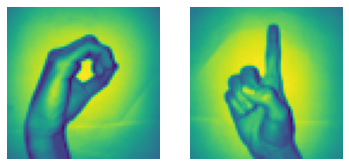

In [55]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

# load data set
x_l = np.load("X.npy")
Y_l = np.load("Y.npy")
img_size = 64
plt.subplot(1, 2, 1)
plt.imshow(x_l[260].reshape(img_size, img_size))
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(x_l[900].reshape(img_size, img_size))
plt.axis('off')

In [86]:
# Join a sequence of arrays along an row axis.
# from 0 to 204 is zero sign and from 205 to 410 is one sign 
X = np.concatenate((x_l[204:409], x_l[822:1027] ), axis=0) 
z = np.zeros(205)
o = np.ones(205)
Y = np.concatenate((z, o), axis=0).reshape(X.shape[0],1)
print("X shape: " , X.shape)
print("Y shape: " , Y.shape)

X shape:  (410, 64, 64)
Y shape:  (410, 1)


The shape of the X is (410, 64, 64)

- 410 means that we have 410 images (zero and one signs)

- 64 means that our image size is 64x64 (64x64 pixels)

The shape of the Y is (410,1)

- 410 means that we have 410 labels (0 and 1)

Lets split X and Y into train and test sets.

- test_size = percentage of test size. test = 15% and train = 75%

- random_state = use same seed while randomizing. It means that if we call train_test_split repeatedly, it always creates same train and test distribution because we have same random_state.

In [138]:
# Then lets create x_train, y_train, x_test, y_test arrays
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.15, random_state=42)

y_train = np.array(Y_train, dtype=np.uint8).flatten()
y_test = np.array(Y_test, dtype=np.uint8).flatten()
print(f"Interval of X_train: (", np.min(X_train), ",", np.max(X_train), ")")
print(f"Interval of X_test: (", np.min(X_test), ",", np.max(X_test), ")")

Interval of X_train: ( 0.02745098 , 1.0 )
Interval of X_test: ( 0.019607844 , 1.0 )


### Image Flattenting

Simple dense neural networks pass feature vectors into the 0-th (the first) layer of the computational graph represented by the neural network structure as column vectors. This 0-th layer is essentially the same as with single neuron models. In order to feed our images into such a network we must flatten the matrix into a column vector.

<img src="flatten.png" width="500" align="center"/>

The numerical values in the flattened training and testing data matrices vary between 0 and 1. It's not necessary to scale the data. Let's flatten.

In [110]:
# Flatten the training images into coloumn vectors. 
flat_train_X = []
# One hot encode the training labels
onehot_train_y = []

for x, y in zip(X_train, y_train):
    flat_train_X.append(x.flatten().reshape(4096, 1))
    temp_vec = np.zeros((2, 1))
    temp_vec[y][0] = 1.0
    onehot_train_y.append(temp_vec)
   

# Do the same for the testing data 
flat_test_X = []
onehot_test_y = []

for x, y in zip(X_test, y_test):
    flat_test_X.append(x.flatten().reshape(4096, 1))
    temp_vec = np.zeros((2, 1))
    temp_vec[y] = 1.0
    onehot_test_y.append(temp_vec)

flat_train_X = np.array(flat_train_X)
flat_test_X = np.array(flat_test_X)
onehot_train_y = np.array(onehot_train_y)
onehot_test_y = np.array(onehot_test_y)

print("X train flatten", flat_train_X.shape)
print("X test flatten",flat_test_X.shape)
print("Y train flatten", onehot_train_y.shape)
print("Y test flatten", onehot_test_y.shape)

X train flatten (348, 4096, 1)
X test flatten (62, 4096, 1)
Y train flatten (348, 2, 1)
Y test flatten (62, 2, 1)


We have 348 images and each image has 4096 pixels in image train array. Also, we have 62 images and each image has 4096 pixels in image test array.

## Building the Network Architecture

For our purposes, we will build a multilayered fully connected, or dense, neural network with L layers, 4096(64x64) input notes, L-2 hidden layers of arbitrary size, and 2 output nodes.

Sigmoid Function: $$\sigma(z) = \frac{1}{1+e^{-z}}$$

Cost Fucntion: $$C(W, b) = \frac{1}{2}\sum_{k=1}^{2}(\hat{y}^{(i)}_k - y^{(i)}_k)^2$$

First we will define our sigmoid activation function, its derivative, and the mean squared error for a single instance of training data. 

In [111]:
def sigmoid(z):
    return 1.0/(1.0+np.exp(-z))

def d_sigmoid(z):
    return sigmoid(z)*(1.0 - sigmoid(z))

def mse(a, y):
    return .5*sum((a[i] - y[i])**2 for i in range(2))[0]

Next we will write a custom function to initialize the weight matrices and bias column vectors for a dense neural network. 

In [112]:
def initialize_weights(layers = [4096, 60, 60, 2]):
    # The following Python lists will contain numpy matrices
    # connected the layers in the neural network 
    W = [[0.0]]
    B = [[0.0]]
    for i in range(1, len(layers)):
        # The scalling factor is something I found in a research paper :)
        w_temp = np.random.randn(layers[i], layers[i-1])*np.sqrt(2/layers[i-1])
        b_temp = np.random.randn(layers[i], 1)*np.sqrt(2/layers[i-1])
    
        W.append(w_temp)
        B.append(b_temp)
    return W, B

##  Feedforward Phase

For $\ell = 1, \dots, L$, each layer $\ell$ in our network will have two phases, the preactivation phase $$\mathbf{z}^{\ell} = W^{\ell}\mathbf{a}^{\ell-1} + \mathbf{b}^{\ell},$$ and postactivation phase $$\mathbf{a}^{\ell} = \sigma(\mathbf{z}^{\ell}).$$ The preactivation phase consists of a weighted linear combination of postactivation values in the previous layer. The postactivation values consists of passing the preactivation value through an activation function elementwise. Note $\mathbf{a}^0 = \mathbf{x}^{(i)}$, where $\mathbf{x}^{(i)}$ is the current input data into our network. 

We can test our activation functions and matrix dimensions by running the following code which manually implements the feedforward process on a neural network with the given dimensions in a for-loop function.

In [117]:
def forward_pass(W, B, xi, predict_vector = False):
    Z = [[0.0]]
    A = [xi]
    L = len(W) - 1
    for i in range(1, L + 1):
        z = W[i] @ A[i-1] + B[i]
        Z.append(z)
        
        a = sigmoid(z)
        A.append(a)
        
    if predict_vector == False:
        return Z, A
    else:
        return A[-1]

def predict(W, B, xi):
    _, A = forward_pass(W, B, xi)
    return np.argmax(A[-1])

y_hat = forward_pass(W, B, flat_train_X[0], predict_vector=True)
print(f"Prediction: np.argmax(y_hat) = {np.argmax(y_hat)}")
print(f"Target Label: np.argmax(yi) = {np.argmax(yi)}")
print(f"mse(y_hat, yi) = {mse(y_hat, yi)}")

Prediction: np.argmax(y_hat) = 1
Target Label: np.argmax(yi) = 1
mse(y_hat, yi) = 0.23061095703981233


Let us next write a custom function for making a prediction on a random data point, as well as write a mean squared error function that computes the error over an entire set of features and labels.

In [116]:
def random_experiment(W, B, data_features, data_labels):
    i = np.random.randint(len(data_features))
    print(f"Actual label: {np.argmax(data_labels[i])}")
    print(f"Predicted label: {predict(W, B, data_features[i])}")
    

def MSE(W, B, X, y):
    cost = 0.0
    m = 0
    for xi, yi in zip(X, y):
        a = forward_pass(W, B, xi, predict_vector = True)
        cost += mse(a, yi)
        m+=1
    return cost/m

print(f"MSE(W, B, flat_train_X, onehot_train_y) = {MSE(W, B, flat_train_X, onehot_train_y)} \n")

random_experiment(W, B, flat_train_X, onehot_train_y)

MSE(W, B, flat_train_X, onehot_train_y) = 0.27308365470947743 

Actual label: 0
Predicted label: 1


## Backpropogation Phase with Stochastic Gradient Descent 

We are now ready to define a custom Python ```DenseNetwork``` class which initializes the weights and bias for the network, and implements stochastic gradient descent shown below:

1. For each $i = 1, \dots, N$.

2. Feedforward $\mathbf{x}^{(i)}$ into the network. 

3. Compute $\delta^{L} = \nabla_aC\otimes \sigma'(\mathbf{z}^{L})$.

4. For $\ell = L-1, \dots, 1$, compute $\delta^{\ell} = \big ( (\mathbf{w}^{\ell + 1})^{T} \delta^{\ell + 1} \Big )\otimes \sigma'(\mathbf{z}^{\ell})$.

5. For $\ell = L, L-1, \dots, 1$, 

$$
w^{\ell} \leftarrow w^{\ell} - \alpha \delta^{\ell}(\mathbf{a}^{\ell-1})^{T}
$$

$$
b^{\ell} \leftarrow b^{\ell} - \alpha \delta^{\ell}
$$

In [124]:
class DenseNetwork(object):
    def __init__(self, layers = [4096, 60, 60, 2]):
        self.layers = layers
        self.W, self.B = initialize_weights(layers = self.layers)

    def train(self, X_train, y_train, alpha = 0.05, epochs = 15):
        # Print the initial mean squared error
        self.errors_ = [MSE(self.W, self.B, X_train, y_train)]
        print(f"Starting Cost = {self.errors_[0]}")

        # Find your sample size
        sample_size = len(X_train)

        # Find the number of non-input layers.
        L = len(self.layers) - 1

        # For each epoch perform stochastic gradient descent. 
        for k in range(epochs):
            # Loop over each (xi, yi) training pair of data.
            for xi, yi in zip(X_train, y_train):
                # Use the forward pass function defined before
                # and find the preactivation and postactivation values.
                Z, A = forward_pass(self.W, self.B, xi)

                # Store the errors in a dictionary for clear interpretation
                # of computation of these values.
                deltas = dict()

                # Compute the output error 
                output_error = (A[L] - yi)*d_sigmoid(Z[L])
                deltas[L] = output_error

                # Loop from L-1 to 1. Recall the right entry of the range function 
                # is non-inclusive. 
                for i in range(L-1, 0, -1):
                    # Compute the node errors at each hidden layer
                    deltas[i] = (self.W[i+1].T @ deltas[i+1])*d_sigmoid(Z[i])

                # Loop over each hidden layer and the output layer to perform gradient 
                # descent. 
                for i in range(1, L+1):
                    self.W[i] -= alpha*deltas[i] @ A[i-1].T
                    self.B[i] -= alpha*deltas[i]

            # Show the user the cost over all training examples
            self.errors_.append(MSE(self.W, self.B, X_train, y_train))   
            print(f"{k + 1}-Epoch Cost = {self.errors_[-1]}")
    

    def predict(self, xi):
        depth = len(self.layers)
        _, A = forward_pass(self.W, self.B, xi)
        return np.argmax(A[-1])

Next, we initialize a network with 4096 input nodes, two hidden layers with 60 nodes each and a output layer with 2 nodes.

MSE(net.W, net.B, flat_train_X, onehot_train_y) = 0.291624711264427 

predicted digit is: 1
actual digit is: 0


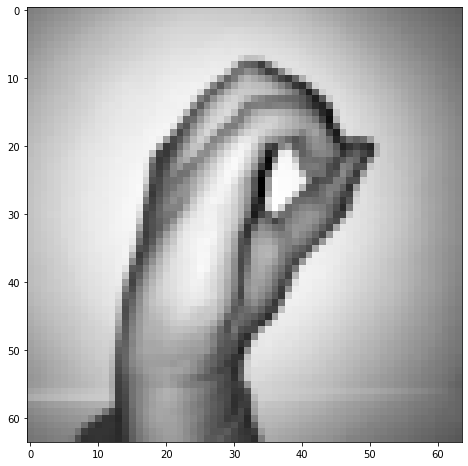

In [126]:
net = DenseNetwork(layers = [4096, 120, 145, 120, 2])

# Check the mean squared error before training 
print(f"MSE(net.W, net.B, flat_train_X, onehot_train_y) = {MSE(net.W, net.B, flat_train_X, onehot_train_y)} \n")

# Make a random prediction before training
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

The prediction is wrong.

Next, train our network with stochastic gradient descent!

In [127]:
net.train(flat_train_X, onehot_train_y)

Starting Cost = 0.291624711264427
1-Epoch Cost = 0.25171737974093705
2-Epoch Cost = 0.24790101565702496
3-Epoch Cost = 0.24092402694159773
4-Epoch Cost = 0.22517095377529223
5-Epoch Cost = 0.18454831500612062
6-Epoch Cost = 0.11658928617546997
7-Epoch Cost = 0.08344098836028842
8-Epoch Cost = 0.0741546265160382
9-Epoch Cost = 0.06640096872857695
10-Epoch Cost = 0.06880958037676903
11-Epoch Cost = 0.08917722672164555
12-Epoch Cost = 0.1260267434252163
13-Epoch Cost = 0.13482944744924746
14-Epoch Cost = 0.13516642771318482
15-Epoch Cost = 0.125212866723242


Let's visualize the mean squared error over the training process.

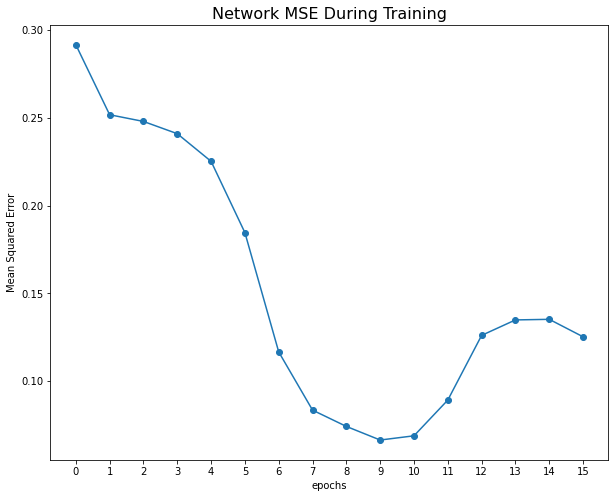

In [128]:
plt.figure(figsize = (10, 8))
epochs = range(len(net.errors_))
plt.plot(epochs, net.errors_, marker = "o")
plt.xticks(epochs)
plt.xlabel("epochs")
plt.ylabel("Mean Squared Error")
plt.title("Network MSE During Training", fontsize = 16)
plt.show()

From the plot, we can see the MSE has the minimum at epochs=9.

Now, after training our dataset, let's see if the prediction results become better by three random predictions.

predicted digit is: 1
actual digit is: 1


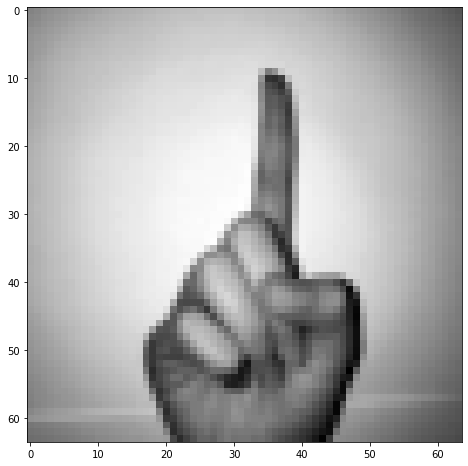

In [130]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

predicted digit is: 1
actual digit is: 1


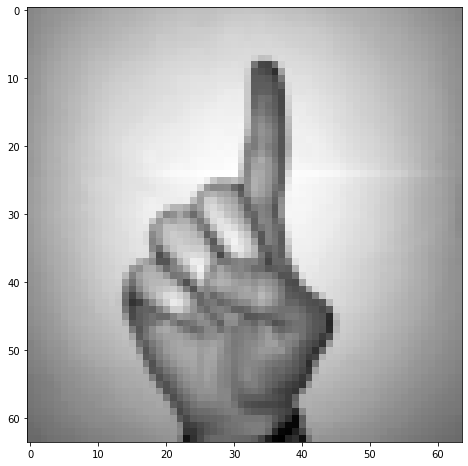

In [131]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

predicted digit is: 0
actual digit is: 0


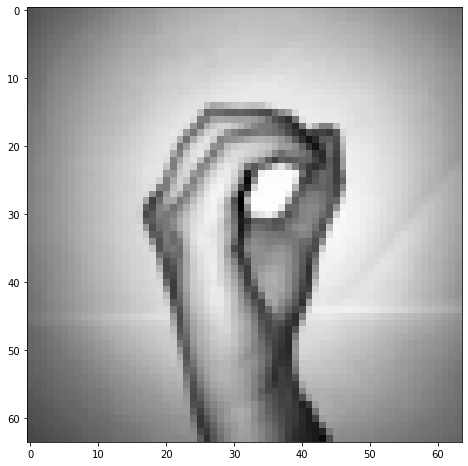

In [132]:
i = np.random.randint(0, len(flat_test_X))
prediction = net.predict(flat_test_X[i])
print(f"predicted digit is: {prediction}")
print(f"actual digit is: {np.argmax(onehot_test_y[i])}")
plt.figure(figsize=(8, 8))
plt.imshow(X_test[i], cmap="gray")
plt.show()

**All the predictions are right!!! That's a great predict!**

## Classification Error

Let us now calculate the classification percentage on the testing data for our trained dense neural network.

In [137]:
# Compute the classification accuracy of our trained model on the test data
sum([int(net.predict(x) == y) for x, y in zip(flat_test_X, y_test)])/len(onehot_test_y)

0.8225806451612904

The value above is close to 1. We do did well!